In [ ]:
!pip install -q -U kaggle_environments

In [123]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
from operator import index
import collections
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



from kaggle_environments import make, evaluate

In [126]:
%%writefile rock_agent.py

#Example of the simple agent
#0 - rock
#1 - paper
#2 - scissors
def rock_agent(observation, configuration):
    return 0

Overwriting rock_agent.py


In [158]:
%%writefile paper.py

#strategy with only papers
def paper(observation, configuration):
    return 1

Overwriting paper.py


In [159]:
%%writefile scissors.py

# strategy with only scissors
def scissors(observation, configuration):
    return 2

Overwriting scissors.py


In [160]:
%%writefile copy_opponent.py

import random  # Добавляем импорт random

def copy_opponent(observation, configuration):
    # Если у нас есть информация о последнем ходе противника
    if observation.step > 0:
        return observation.lastOpponentAction
    # Начальный шаг
    else:
        return random.randrange(0, configuration.signs)


Overwriting copy_opponent.py


In [161]:
%%writefile keep_strategy.py
import random
import math
my_action = []

def keep_strategy(observation, configuration):
    def get_score(left_move, right_move):
        delta = (
            right_move - left_move
            if (left_move + right_move) % 2 == 0
            else left_move - right_move
        )
        return 0 if delta == 0 else math.copysign(1, delta)
    global my_action
    if observation.step == 0:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    elif get_score(my_action[-1], observation.lastOpponentAction) == 1:
        answer = my_action[-1]
        my_action.append(answer)
    else:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    return answer

Overwriting keep_strategy.py


In [162]:
%%writefile throw_paper_if_win.py
import random
import math
my_action = []

def keep_strategy(observation, configuration):
    def get_score(left_move, right_move):
        delta = (
            right_move - left_move
            if (left_move + right_move) % 2 == 0
            else left_move - right_move
        )
        return 0 if delta == 0 else math.copysign(1, delta)
    global my_action
    if observation.step == 0:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    elif get_score(my_action[-1], observation.lastOpponentAction) == 1:
        answer = 1
        my_action.append(answer)
    else:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    return answer

Overwriting throw_paper_if_win.py


In [163]:
%%writefile random_full.py
import random
def random_full(observation, configuration):
    return random.randint(0, 2)

Overwriting random_full.py


In [164]:
%%writefile scissors_if_lose.py
import random
import math

my_action = []

def keep_strategy(observation, configuration):
    """
    Keep stategy if win
    """
    def get_score(left_move, right_move):
        # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
        delta = (
            right_move - left_move
            if (left_move + right_move) % 2 == 0
            else left_move - right_move
        )
        return 0 if delta == 0 else math.copysign(1, delta)
    global my_action
    if observation.step == 0:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    elif get_score(my_action[-1], observation.lastOpponentAction) < 1:
        answer = 2
        my_action.append(answer)
    else:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    return answer

Overwriting scissors_if_lose.py


In [165]:
%%writefile agent_ghisto.py
import random
def statistical(observation, configuration):
  # Глобальная переменная для хранения гистограммы действий
    global action_histogram
    if observation.step == 0:
      # Инициализируем гистограмму действий
        action_histogram = {}
        return
    action = observation.lastOpponentAction # Получаем последнее действие противника

    #Если действие противника отсутствует в гистограмме, добавляем его
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None    #Переменная для хранения наиболее частого действия
    mode_action_count = None  # Переменная для хранения частоты этого действия


# Итерируем по всем записям гистограммы для поиска наиболее частого действия
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting agent_ghisto.py


In [166]:
%%writefile fixed_statistic.py
import random
import numpy

def fixed_statistic(observation, configuration):
    all_results = [0]*int(configuration.episodeSteps*0.354)+[1]*int(configuration.episodeSteps*0.296) +\
     [2]*int(configuration.episodeSteps*0.35)
    return random.choice(all_results)

Overwriting fixed_statistic.py


In [167]:
%%writefile neural_network.py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Инициализация модели нейронной сети
model = Sequential([
    Dense(32, input_shape=(6,), activation="relu"),  # Входные данные — 6 последних ходов
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")  # Выход — вероятности для "Камень", "Бумага", "Ножницы"
])

# Компиляция модели
model.compile(optimizer="adam", loss="categorical_crossentropy")

# Инициализация памяти ходов с начальным значением
history = [0, 0, 0, 0, 0, 0]  # Начальная последовательность, чтобы избежать ошибок при первых шагах

def neural_network_agent(observation, configuration):
    global history

    # Добавляем предыдущий ход соперника и наш ход в историю
    if observation.step > 0:
        history.extend([observation.lastOpponentAction, history[-1]])

    # Если данных недостаточно, выбираем случайный ход
    if len(history) < 6:
        action = int(np.random.randint(3))
        history.append(action)
        return action

    # Формируем входные данные из последних 6 ходов
    input_data = np.array(history[-6:]).reshape(1, -1)

    # Прогнозируем следующий ход соперника
    opponent_pred = np.argmax(model.predict(input_data)[0])

    # Выбираем действие, которое побеждает предсказанный ход соперника
    action = (opponent_pred + 1) % 3
    history.append(action)


    return int(action)


Overwriting neural_network.py


In [168]:
%%writefile markov.py
import numpy as np
import collections

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0:
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum())
    action = (next_opponent_action_pred + 1) % 3
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Overwriting markov.py


In [169]:
%%writefile decision_tree.py

import numpy as np
import collections
from sklearn.tree import DecisionTreeClassifier

def construct_local_features(rollouts):
    step_mode_features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
    step_div_features = np.array([[step // k for step in rollouts['steps']] for k in (100, 150, 250)])
    features = np.concatenate([step_mode_features, step_div_features])
    features = np.append(features, rollouts['actions'])
    features = np.append(features, rollouts['opp-actions'])
    return features

def construct_global_features(rollouts):
    features = []
    for key in ['actions', 'opp-actions']:
        for i in range(3):
            actions_count = np.mean([r == i for r in rollouts[key]])
            features.append(actions_count)
    return np.array(features)

def construct_features(short_stat_rollouts, long_stat_rollouts):
    lf = construct_local_features(short_stat_rollouts)
    gf = construct_global_features(long_stat_rollouts)
    features = np.concatenate([lf, gf])
    return features

def predict_opponent_move(train_data, test_sample):
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(train_data['x'], train_data['y'])
    return classifier.predict(test_sample)

def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
    rollouts_hist['steps'].append(last_move['step'])
    rollouts_hist['actions'].append(last_move['action'])
    rollouts_hist['opp-actions'].append(opp_last_action)
    return rollouts_hist

def warmup_strategy(observation, configuration):
    global rollouts_hist, last_move
    action = int(np.random.randint(3))
    if observation.step == 0:
        last_move = {'step': 0, 'action': action}
        rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
    else:
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        last_move = {'step': observation.step, 'action': action}
    return int(action)

def init_training_data(rollouts_hist, k):
    for i in range(len(rollouts_hist['steps']) - k + 1):
        short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
        long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, long_stat_rollouts)
        data['x'].append(features)
    test_sample = data['x'][-1].reshape(1, -1)
    data['x'] = data['x'][:-1]
    data['y'] = rollouts_hist['opp-actions'][k:]
    return data, test_sample

def agent(observation, configuration):
    # hyperparameters
    k = 5
    min_samples = 25
    global rollouts_hist, last_move, data, test_sample
    if observation.step == 0:
        data = {'x': [], 'y': []}
    # if not enough data -> randomize
    if observation.step <= min_samples + k:
        return warmup_strategy(observation, configuration)
    # update statistics
    rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
    # update training data
    if len(data['x']) == 0:
        data, test_sample = init_training_data(rollouts_hist, k)
    else:
        short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, rollouts_hist)
        data['x'].append(test_sample[0])
        data['y'] = rollouts_hist['opp-actions'][k:]
        test_sample = features.reshape(1, -1)

    # predict opponents move and choose an action
    next_opp_action_pred = predict_opponent_move(data, test_sample)
    action = int((next_opp_action_pred + 1) % 3)
    last_move = {'step': observation.step, 'action': action}
    return action

Overwriting decision_tree.py


In [170]:
%%writefile geometry.py
import operator
import numpy as np
import cmath
from typing import List
from collections import namedtuple
import traceback
import sys


basis = np.array(
    [1, cmath.exp(2j * cmath.pi * 1 / 3), cmath.exp(2j * cmath.pi * 2 / 3)]
)


HistMatchResult = namedtuple("HistMatchResult", "idx length")


def find_all_longest(seq, max_len=None) -> List[HistMatchResult]:
    """
    Find all indices where end of `seq` matches some past.
    """
    result = []

    i_search_start = len(seq) - 2

    while i_search_start > 0:
        i_sub = -1
        i_search = i_search_start
        length = 0

        while i_search >= 0 and seq[i_sub] == seq[i_search]:
            length += 1
            i_sub -= 1
            i_search -= 1

            if max_len is not None and length > max_len:
                break

        if length > 0:
            result.append(HistMatchResult(i_search_start + 1, length))

        i_search_start -= 1

    result = sorted(result, key=operator.attrgetter("length"), reverse=True)

    return result


def probs_to_complex(p):
    return p @ basis


def _fix_probs(probs):
    if min(probs) < 0:
        probs -= min(probs)

    probs /= sum(probs)

    return probs


def complex_to_probs(z):
    probs = (2 * (z * basis.conjugate()).real + 1) / 3
    probs = _fix_probs(probs)
    return probs


def z_from_action(action):
    return basis[action]


def sample_from_z(z):
    probs = complex_to_probs(z)
    return np.random.choice(3, p=probs)


def bound(z):
    return probs_to_complex(complex_to_probs(z))


def norm(z):
    return bound(z / abs(z))


class Pred:
    def __init__(self, *, alpha):
        self.offset = 0
        self.alpha = alpha
        self.last_feat = None

    def train(self, target):
        if self.last_feat is not None:
            offset = target * self.last_feat.conjugate()   # fixed

            self.offset = (1 - self.alpha) * self.offset + self.alpha * offset

    def predict(self, feat):
        feat = norm(feat)

        result = feat * self.offset

        self.last_feat = feat

        return result


class BaseAgent:
    def __init__(self):
        self.my_hist = []
        self.opp_hist = []
        self.my_opp_hist = []
        self.outcome_hist = []
        self.step = None

    def __call__(self, obs, conf):
        try:
            if obs.step == 0:
                action = np.random.choice(3)
                self.my_hist.append(action)
                return action

            self.step = obs.step

            opp = int(obs.lastOpponentAction)
            my = self.my_hist[-1]

            self.my_opp_hist.append((my, opp))
            self.opp_hist.append(opp)

            outcome = {0: 0, 1: 1, 2: -1}[(my - opp) % 3]
            self.outcome_hist.append(outcome)

            action = self.action()

            self.my_hist.append(action)

            return action
        except Exception:
            traceback.print_exc(file=sys.stderr)
            raise

    def action(self):
        pass


class Agent(BaseAgent):
    def __init__(self, alpha=0.01):
        super().__init__()

        self.predictor = Pred(alpha=alpha)

    def action(self):
        self.train()

        pred = self.preds()

        return_action = sample_from_z(pred)

        return return_action

    def train(self):
        last_beat_opp = z_from_action((self.opp_hist[-1] + 1) % 3)
        self.predictor.train(last_beat_opp)

    def preds(self):
        hist_match = find_all_longest(self.my_opp_hist, max_len=20)

        if not hist_match:
             return 0

        feat = z_from_action(self.opp_hist[hist_match[0].idx])

        pred = self.predictor.predict(feat)

        return pred


agent = Agent()


def call_agent(obs, conf):
    return agent(obs, conf)

Overwriting geometry.py


In [171]:
# Создаем среду для игры "Камень, ножницы, бумага"
env = make("rps",configuration={"episodeSteps": 1000}, debug=True)


In [172]:
agents = [file for file in os.listdir() if file.endswith('.py')]
agents
dict_win = {agent: [0, 0, 0] for agent in agents}

In [173]:
np.rps = []
for i in range(len(agents)):
  np.rps_row = []
  a = 0
  for j in range(len(agents)):
    one_set = []
    one_set = evaluate(
                        "rps",
                        [agents[i], agents[j]],
                        configuration={"episodeSteps": 70, 'tieRewardThreshold': 1}
                      )
    print(agents[i], agents[j])
    np.rps_row += one_set
    print(one_set)
    if one_set[0][0] > one_set[0][1]:
      dict_win[agents[i]][0] += 1
    elif one_set[0][0] < one_set[0][1]:
      dict_win[agents[i]][1] += 1
    else:
      dict_win[agents[i]][2] += 1

  np.rps.append(np.rps_row)

rock_agent.py rock_agent.py
[[0, 0]]
rock_agent.py random_full.py
[[10.0, -10.0]]
rock_agent.py paper.py
[[-69.0, 69.0]]
rock_agent.py agent7.py
[[-68.0, 68.0]]
rock_agent.py copy_opponent.py
[[1.0, -1.0]]
rock_agent.py neural_network.py
[[67.0, -67.0]]
rock_agent.py throw_scissors_if_lose.py
[[68.0, -68.0]]
rock_agent.py scissors_if_lose.py
[[65.0, -65.0]]
rock_agent.py decision_tree.py
[[-40.0, 40.0]]
rock_agent.py fixed_statistic.py
[[4.0, -4.0]]
rock_agent.py keep_strategy.py
[[-69.0, 69.0]]
rock_agent.py agent_ghisto.py
[[-68.0, 68.0]]
rock_agent.py throw_paper_if_win.py
[[-47.0, 47.0]]
rock_agent.py scissors.py
[[69.0, -69.0]]
rock_agent.py geometry.py
[[-10.0, 10.0]]
rock_agent.py markov.py
[[-66.0, 66.0]]
random_full.py rock_agent.py
[[-4.0, 4.0]]
random_full.py random_full.py
[[10.0, -10.0]]
random_full.py paper.py
[[-15.0, 15.0]]
random_full.py agent7.py
[[4.0, -4.0]]
random_full.py copy_opponent.py
[[8.0, -8.0]]
random_full.py neural_network.py
[[-9.0, 9.0]]
random_full.py t

In [174]:
colName = ["Победа", "Поражение", "Ничья"]
df = pd.DataFrame.from_dict(dict_win, orient='index', columns=colName)
df = df.sort_values("Победа",ascending = False)
df

,Победа,Поражение,Ничья
decision_tree.py,15,0,1
fixed_statistic.py,10,5,1
keep_strategy.py,10,4,2
markov.py,10,6,0
agent7.py,9,5,2
scissors_if_lose.py,9,5,2
agent_ghisto.py,9,5,2
random_full.py,8,7,1
neural_network.py,8,8,0
geometry.py,8,4,4


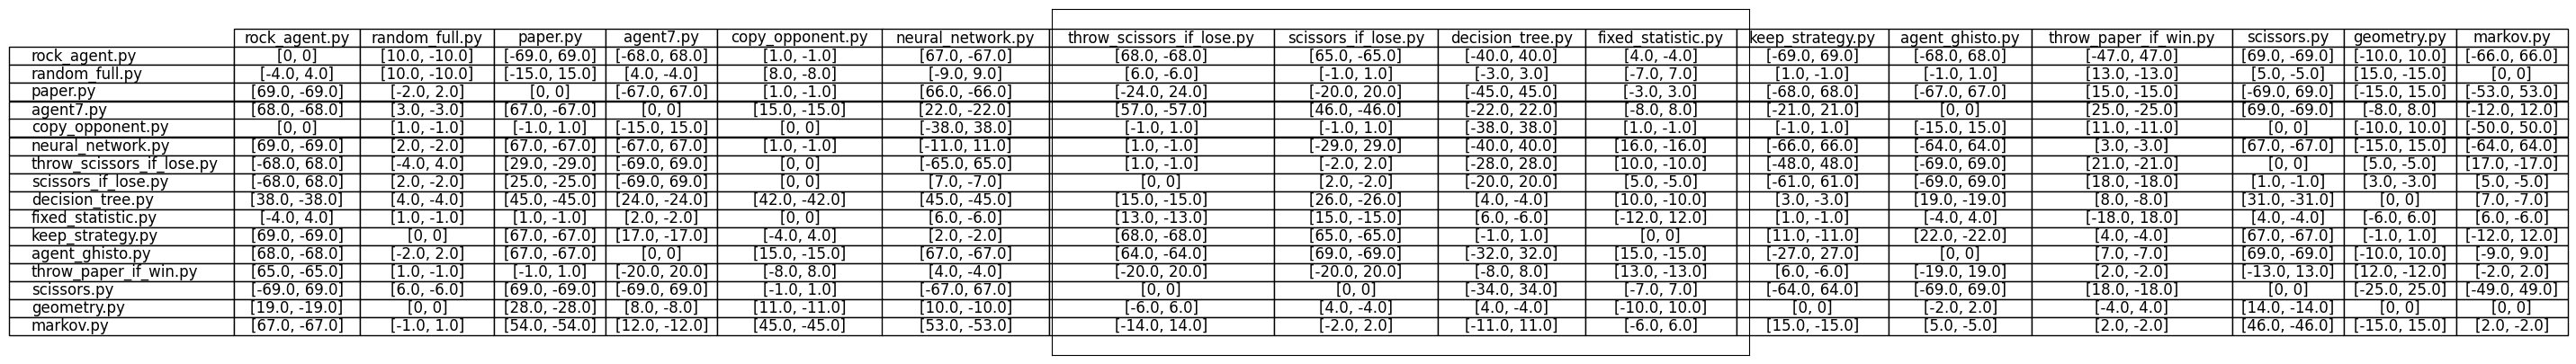

In [177]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

the_table = ax.table(
    cellText=clust_data,
    colLabels=agents,
    rowLabels=agents,
    loc='center',
    cellLoc='center'
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(12)

the_table.scale(1.2, 1.2)

for i in range(len(agents)):
    the_table.auto_set_column_width(col=i)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-183-63b22537e808>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.barplot(


<Axes: xlabel='Победа', ylabel='None'>

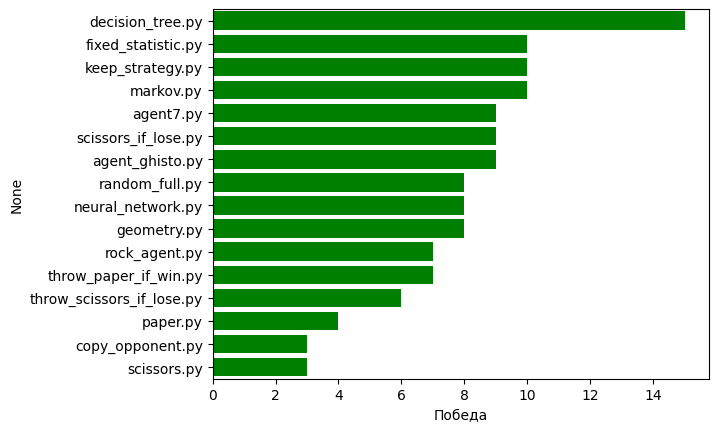

In [183]:
wins = df
for i in df1.index:
    df1["Агент"] = df1.index


sns.barplot(
    x='Победа',
    y=df1.index,
    ci=90,
    color='green',
    saturation=1,
    dodge= False,
    data=df1
)

<Axes: >

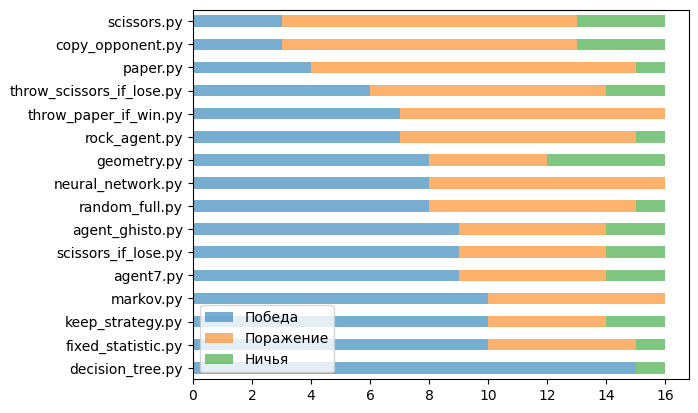

In [185]:

wins.plot.barh(stacked=True, alpha=0.6)